| **Chapter**                   | 9:  Agent-based models                         |
| --- |------------------------------------------------|
| **Computational Note**        | 9.x: Movement in continuous space              |
| **Package prerequisites**     | [Mesa](https://mesa.readthedocs.io/en/latest/) |

# Movement in continuous space

In [10]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import ContinuousSpace
from mesa.datacollection import DataCollector
from matplotlib import pyplot as plt
import seaborn as sns
import json
from scipy import stats
import enum

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [11]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    INFECTED = 2
    RECOVERED = 3
    VACCINATED = 4
    DECEASED = 5

In [12]:
class Person(Agent):
    def __init__(self, uid, model, posx, posy):
        super().__init__(uid, model)

        self.posx = posx
        self.posy = posy

        # Naive start
        self.state = State.SUSCEPTIBLE
        
        self.time_at_infection = 0
        self.time_at_induction_of_immunity = None

    def contact_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False, radius=self.model.reach)
        susceptible_neighbourhood = [agent for agent in neighbourhood if agent.state is State.SUSCEPTIBLE]

        for neighbour in susceptible_neighbourhood:
            if np.random.rand() < model.beta:
                neighbour.state = State.EXPOSED

    def movement_event(self):
        distance = stats.norm.rvs(5, 2)
        angle = stats.uniform(loc=0, scale=360).rvs()

        new_x = self.pos[0] + distance * np.cos(angle)
        new_y = self.pos[1] + distance * np.sin(angle)

        self.model.grid.move_agent(self, (new_x, new_y))

    def status_update(self):
        if self.state == State.EXPOSED:
            if self.model.schedule.time - self.time_at_infection >= model.latency_period.rvs():
                self.state = State.INFECTED
        
        if self.state == State.INFECTED:
            if self.model.schedule.time - self.time_at_infection >= model.latency_period.rvs() + model.recovery_period.rvs():
                if np.random.rand() < model.CFR:
                    self.state = State.DECEASED
                else:
                    self.state = State.RECOVERED
                    self.time_at_induction_of_immunity = self.model.schedule.time

        if np.random.rand() < model.base_mortality_rate:
            self.state = State.DECEASED

        if self.state == State.RECOVERED:
            if self.model.schedule.time - self.time_at_induction_of_immunity > self.model.duration_of_immunity.rvs():
                self.state = State.SUSCEPTIBLE

        if self.state == State.SUSCEPTIBLE:
            neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False, radius=self.model.reach)

            # Simple majority voting quorum sensing
            vaccinated_neighbourhood = [i for i in neighbourhood if i.state == State.VACCINATED]

            if len(neighbourhood) == 0:
                quorum = 0
            else:
                quorum = len(vaccinated_neighbourhood)/len(neighbourhood)

            if np.random.rand() < self.model.base_vaccination_rate + int(quorum >= 0.5) * self.model.homophily_factor_of_vaccination:
                self.state = State.VACCINATED
                self.time_at_induction_of_immunity = self.model.schedule.time

        if self.state == State.VACCINATED:
            if self.model.schedule.time - self.time_at_induction_of_immunity > self.model.duration_of_vaccine_induced_immunity.rvs():
                self.state = State.SUSCEPTIBLE

        self.posx = self.pos[0]
        self.posy = self.pos[1]
        
    def step(self):
        self.status_update()
        self.contact_event()
        self.movement_event()

    def toJSON(self):        
        key = self.unique_id
        return json.dumps(key, default=lambda o: o.__dict__, sort_keys=True, indent=4)

In [13]:
class NetworkInfectiousDiseaseModel(Model):

    def __init__(self, 
                 N_agents=1000,
                 grid_size=(1000, 1000),
                 grid_toroidal=True,
                 latency_period_mu=5,
                 latency_period_sigma=2,
                 recovery_period_mu=14,
                 recovery_period_sigma=5,
                 beta=0.001,
                 CFR=0.05,
                 base_mortality_rate=0.000125,
                 I0=0.005,
                 duration_of_immunity_mu=90,
                 duration_of_immunity_sigma=14,
                 base_vaccination_rate=0.0007,
                 duration_of_vaccine_induced_immunity_mu=90,
                 duration_of_vaccine_induced_immunity_sigma=7,
                 homophily_factor_of_vaccination=3,
                 reach=15):
                     
        self.N_agents = N_agents
        self.latency_period = stats.halfnorm(latency_period_mu, latency_period_sigma)
        self.recovery_period = stats.halfnorm(recovery_period_mu, recovery_period_sigma)
        self.beta = beta
        self.CFR = CFR
        self.base_mortality_rate = base_mortality_rate
        self.duration_of_immunity = stats.halfnorm(duration_of_immunity_mu, duration_of_immunity_sigma)
        self.base_vaccination_rate = base_vaccination_rate
        self.duration_of_vaccine_induced_immunity = stats.halfnorm(duration_of_vaccine_induced_immunity_mu, duration_of_vaccine_induced_immunity_sigma)
        self.homophily_factor_of_vaccination = homophily_factor_of_vaccination
        self.reach = reach

        self.grid = ContinuousSpace(x_max=grid_size[0], y_max=grid_size[1], torus=grid_toroidal)

        self.schedule = RandomActivation(self)
        self.running = True

        for idx in range(self.N_agents):
            x = stats.halfnorm(grid_size[0]/2, 15).rvs()
            y = stats.halfnorm(grid_size[1]/2, 20).rvs()
            agent = Person(uid = idx, model=self, posx=x, posy=y)
            self.schedule.add(agent)
            self.grid.place_agent(agent, (x, y))

            if np.random.rand() < I0:
                agent.state = State.INFECTED

        self.datacollector = DataCollector(agent_reporters={"State": "state"})
        self.positioncollector = DataCollector(agent_reporters={"x": "posx",
                                                                "y": "posy",
                                                                "state": "state"})

    def step(self):
        self.datacollector.collect(self)
        self.positioncollector.collect(self)
        self.schedule.step()

    def to_df(self):
        state_profile = self.datacollector.get_agent_vars_dataframe()
        output_df = pd.pivot_table(state_profile.reset_index(), 
                       index="Step", 
                       columns="State", 
                       aggfunc=np.size, 
                       fill_value=0)
        output_df.columns = [i.title() for i in State.__dict__.get("_member_names_")]
        return output_df

In [14]:
pop=2000
steps=60

model = NetworkInfectiousDiseaseModel(pop, grid_size=(100, 100))

for i in range(steps):
    model.step()

model_results = model.to_df()

In [47]:
positions = model.positioncollector.get_agent_vars_dataframe().reset_index()

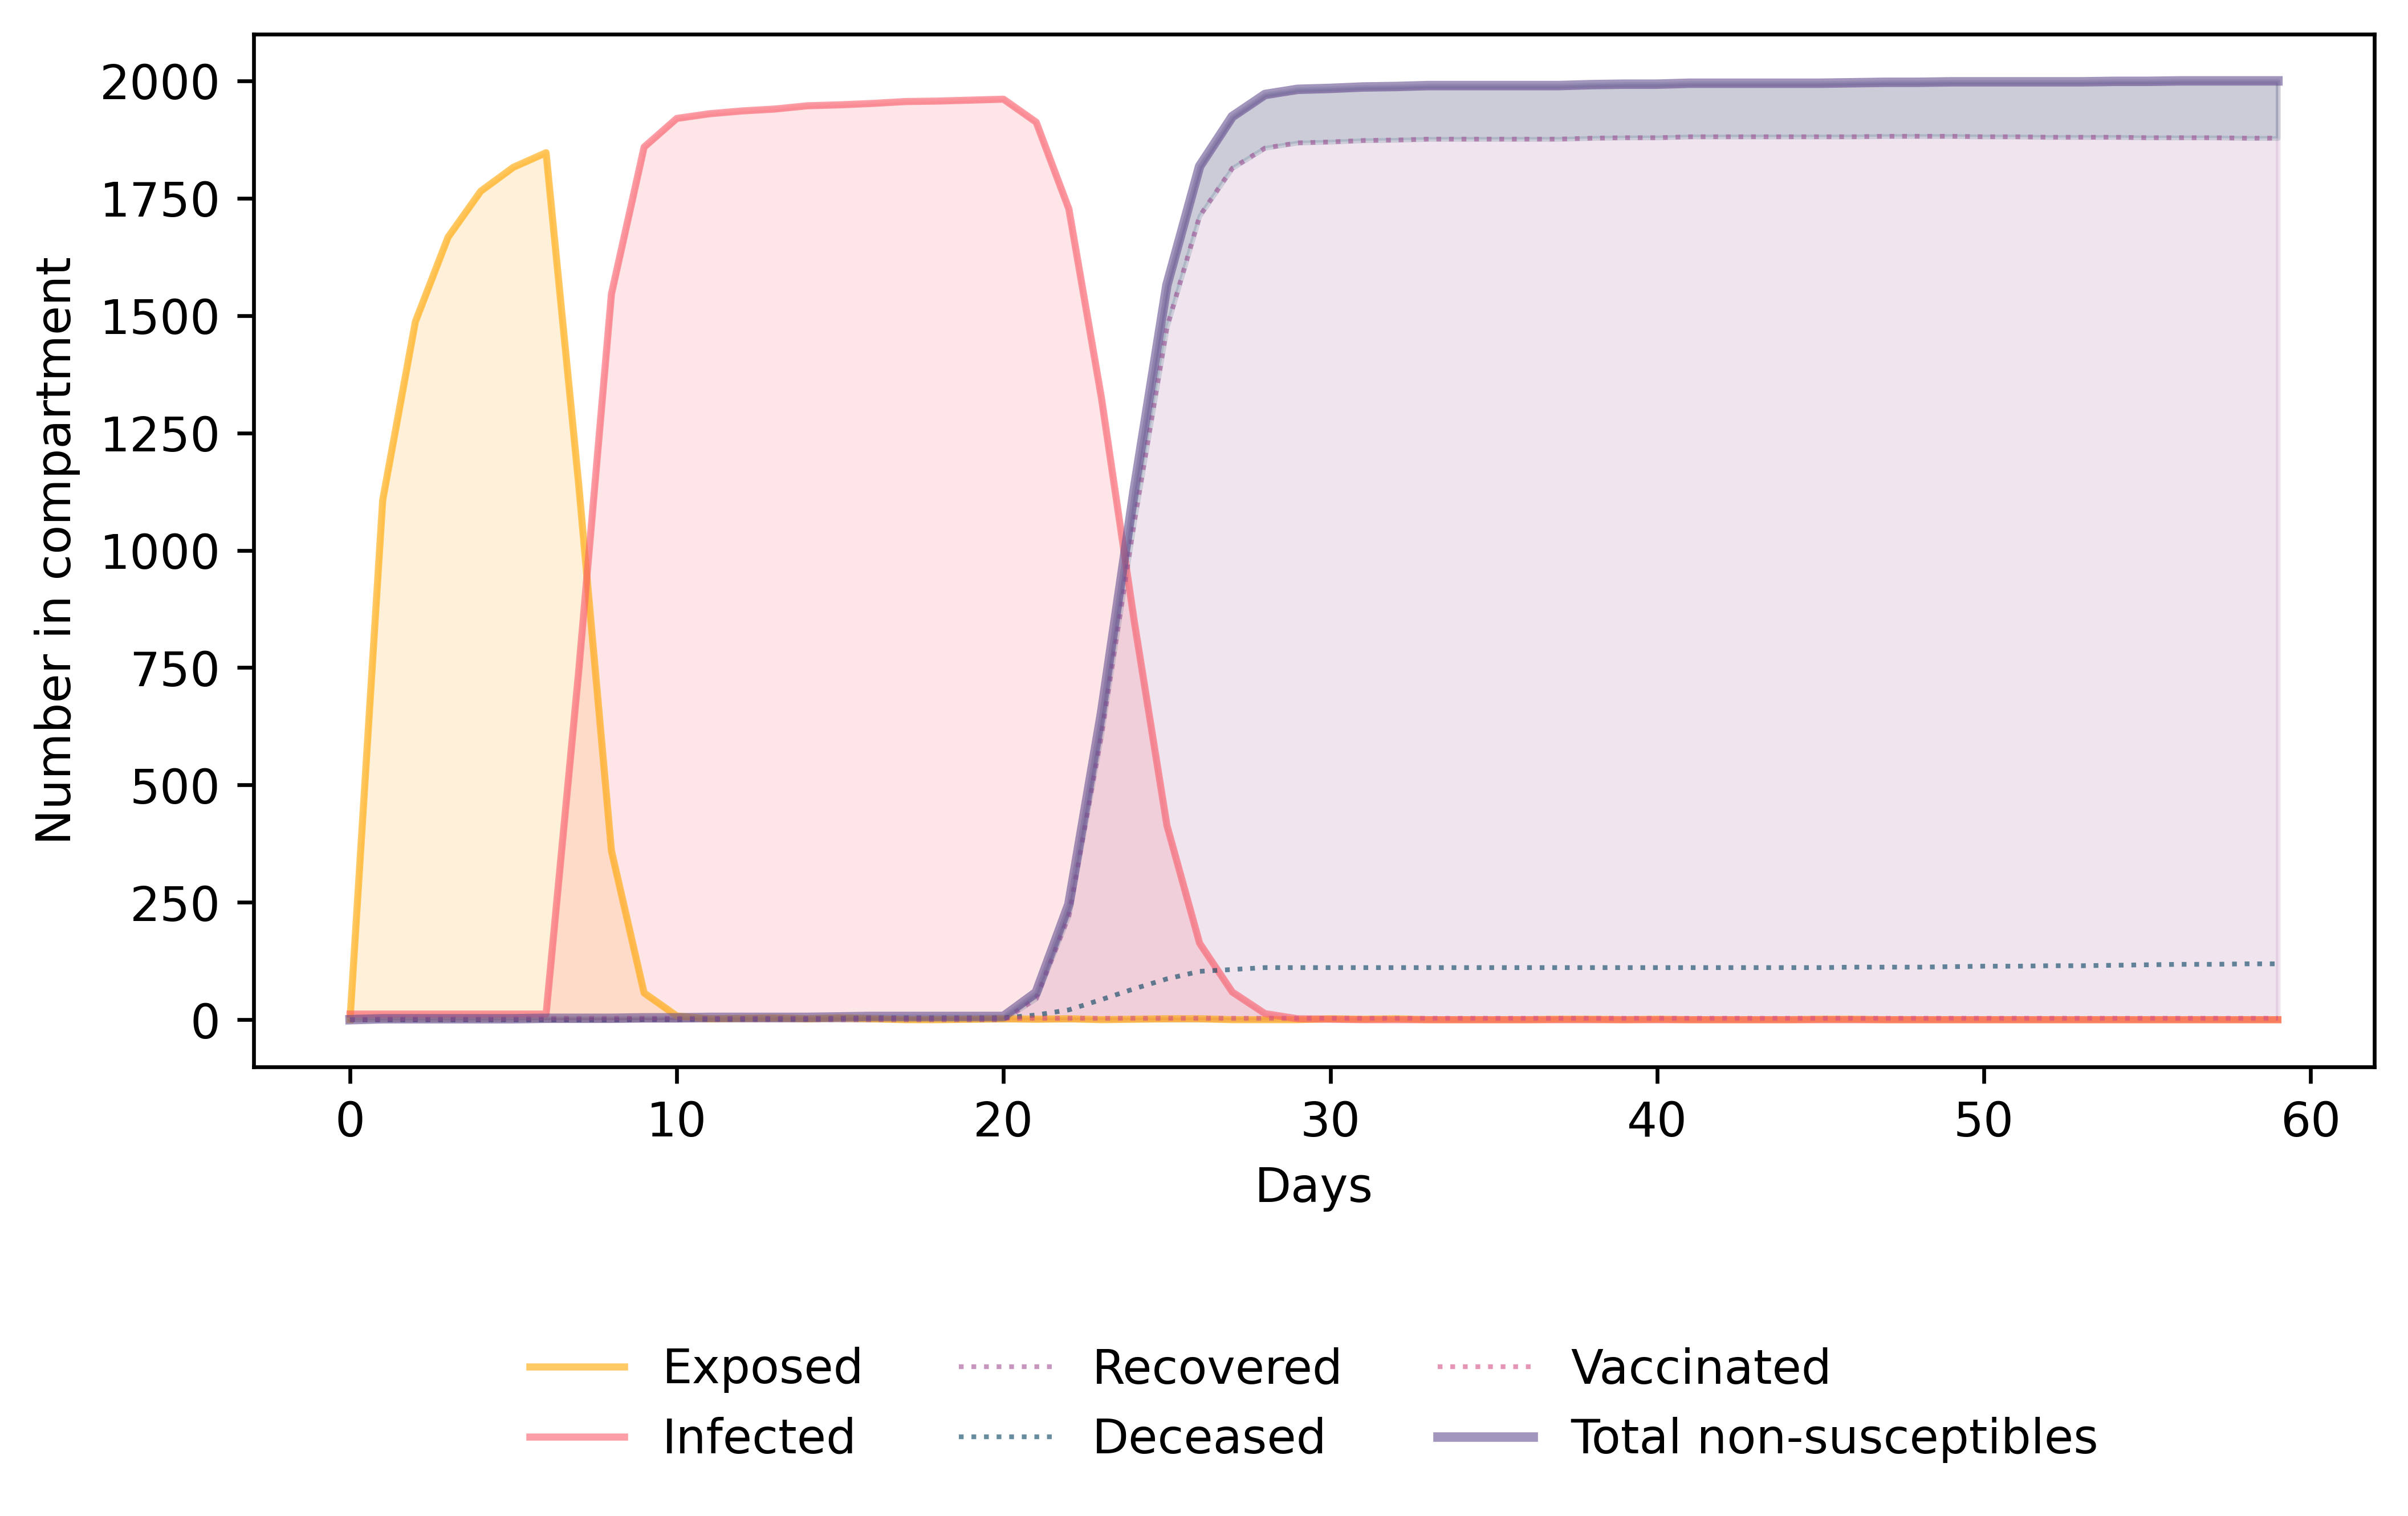

In [16]:
fig = plt.figure(facecolor="w", figsize=(8, 4), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

# plt.plot(model_results.index, model_results.Susceptible, color=COLORS["S"], label="Susceptible")
ax.plot(model_results.index, model_results.Exposed, color=COLORS["E"], alpha=0.6, label="Exposed")
ax.plot(model_results.index, model_results.Infected, color=COLORS["I"], alpha=0.6, label="Infected")
ax.plot(model_results.index, model_results.Recovered, color=COLORS["R"], alpha=0.6, lw=1, linestyle=":", label="Recovered")
ax.plot(model_results.index, model_results.Deceased, color=COLORS["D"], alpha=0.6, lw=1, linestyle=":", label="Deceased")
ax.plot(model_results.index, model_results.Vaccinated, color=COLORS["Y"], alpha=0.6, lw=1, linestyle=":", label="Vaccinated")
ax.plot(model_results.index, model_results.Recovered + model_results.Deceased + model_results.Vaccinated, color=COLORS["X"], alpha=0.6, lw=2, label="Total non-susceptibles")

ax.fill_between(model_results.index, 0, model_results.Exposed, color=COLORS["E"], alpha=0.15)
ax.fill_between(model_results.index, 0, model_results.Infected, color=COLORS["I"], alpha=0.15)
ax.fill_between(model_results.index, 0, model_results.Recovered + model_results.Deceased, color=COLORS["R"], alpha=0.15)
ax.fill_between(model_results.index, model_results.Recovered, model_results.Recovered + model_results.Deceased + model_results.Vaccinated, color=COLORS["D"], alpha=0.15)


legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title="", bbox_to_anchor=(0.5, -0.425), loc="lower center", ncol=3, frameon=False)

ax.set_xlabel("Days")
ax.set_ylabel("Number in compartment")

plt.savefig("continuous_space_SEIRDV.pdf")

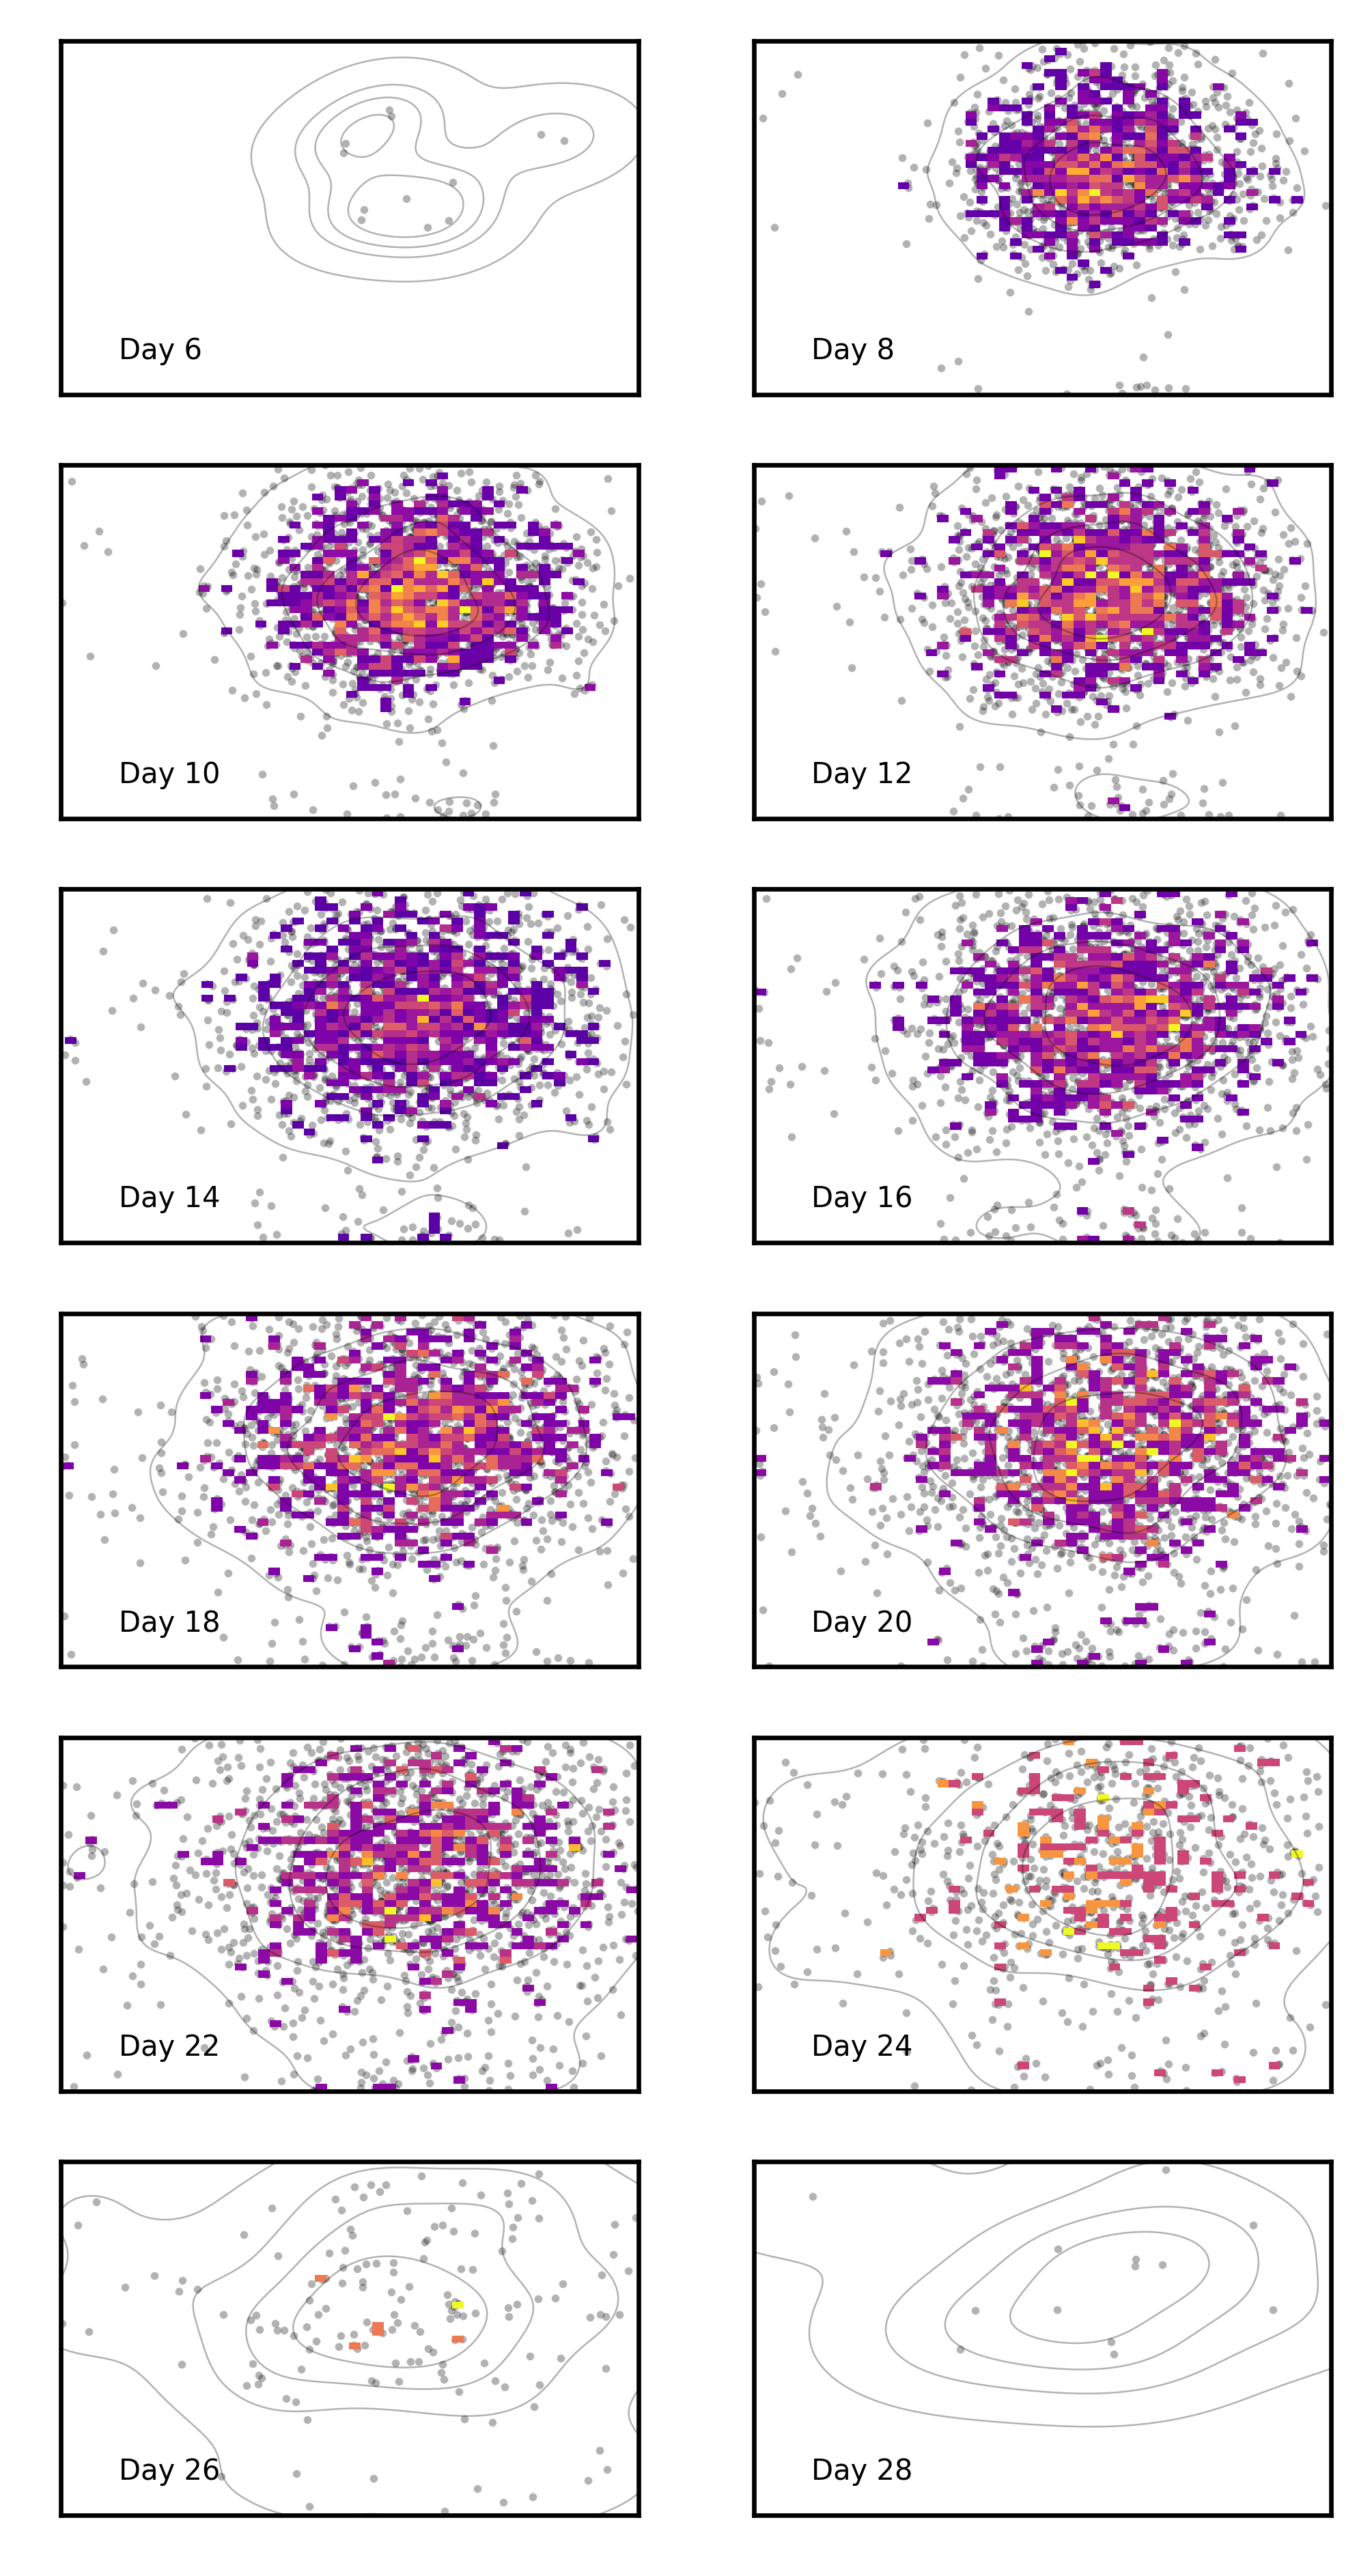

In [87]:
ROWS:int = 6
COLS:int = 2
BASE_OFFSET:int = 6
STEP:int = 2

fig, axs = plt.subplots(nrows=ROWS, ncols=COLS, facecolor="w", figsize=(4, 8), dpi=600)

for i in range(ROWS):
    for j in range(COLS):
        ax = axs[i, j]

        df = positions[(positions.Step == BASE_OFFSET + i * 2 * STEP + j * STEP) & (positions.state == 2)]
    
        sns.scatterplot(x=df.x, y=df.y, s=2, alpha=0.3, color="k", ax=ax)
        sns.histplot(x=df.x, y=df.y, bins=50, pthresh=.1, cmap="plasma", ax=ax)
        sns.kdeplot(x=df.x, y=df.y, levels=5, color="k", alpha=0.3, linewidths=0.3, ax=ax)
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.annotate(f"Day {BASE_OFFSET + i * 2 * STEP + j * STEP}", (10, 10), fontsize=5)

        ax.set_ylim(0, 100)
        ax.set_xlim(0, 100)

plt.savefig("continuous_space_SEIRDV_kde.pdf")